In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import time

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs.csv", nrows=400000)
costs.shape

(400000, 17)

In [4]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


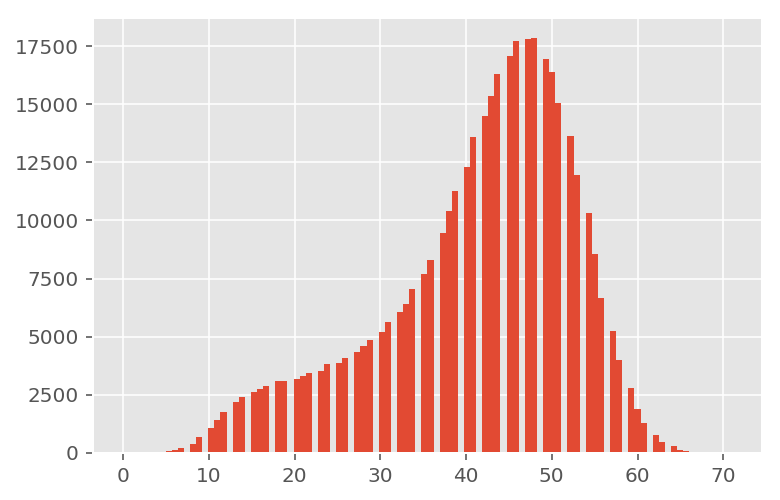

In [5]:
costs['cost'].hist(bins=100)

In [6]:
X = costs.iloc[:,:-1].values.copy()
y = costs['cost'].values.copy()

In [7]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(categories='auto')
X = one_hot_encoder.fit_transform(X).toarray();

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = map(
    lambda x: torch.tensor(x, dtype=torch.float).to(device), train_test_split(X, y, test_size=0.2, random_state=42)
)

In [9]:
from torch.utils.data import Dataset

class CostsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
from torch.utils.data import DataLoader

train_dataset = CostsDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256)
valid_dataset = CostsDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=256)

In [32]:
class Net(torch.nn.Module):
    def __init__(self, layer_sizes):        
        D_in = layer_sizes[0]
        hidden_sizes = layer_sizes[1:-1]
        D_out = layer_sizes[-1]
        
        super(Net, self).__init__()
        self.fc_in = torch.nn.Linear(D_in, hidden_sizes[0])
        torch.nn.init.kaiming_normal_(self.fc_in.weight)
        self.bn_in = torch.nn.BatchNorm1d(hidden_sizes[0])
        
        self.fc_hidden = []
        self.bn_hidden = []
        for Ha, Hb in zip(hidden_sizes, hidden_sizes[1:]):
            fc = torch.nn.Linear(Ha, Hb)
            torch.nn.init.kaiming_normal_(fc.weight)
            self.fc_hidden.append(fc)
            self.bn_hidden.append(torch.nn.BatchNorm1d(Hb))
        
        self.fc_out = torch.nn.Linear(hidden_sizes[-1], D_out)
        torch.nn.init.kaiming_normal_(self.fc_out.weight)
        
    def forward(self, x):
#         x = self.bn_in(F.elu(self.fc_in(x)))
        x = F.elu(self.fc_in(x))
        for fc_h, bn_h in zip(self.fc_hidden, self.bn_hidden):
#             x = bn_h(F.elu(fc_h(x)))
            x = F.elu(fc_h(x))
        x = self.fc_out(x)
        return x
    

model = Net([256, 128, 1])
model.to(device)
for component in model.fc_hidden:
    component.to(device)
for component in model.bn_hidden:
    component.to(device)

# model = torch.nn.Sequential(
#           torch.nn.Linear(256, 128),
#           torch.nn.ReLU(),
#           torch.nn.Linear(128, 1),
# ).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=0)

In [33]:
from IPython.display import display, clear_output

n_epochs = 1
outputs = []
for epoch in range(n_epochs):
    start_time = time.time()
    last_output = None
    model.train()
    train_loss = 0
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        clear_output(wait=True)
        
        loss = loss_fn(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        last_output = f"Epoch {epoch + 1}/{n_epochs}:batch {i + 1}/{len(train_dataloader)}, train loss: {round(train_loss / (i + 1), 4)}"
        display(outputs + [last_output])
    
    model.eval()
    test_loss = 0
    for i, (x_batch, y_batch) in enumerate(valid_dataloader):
        loss = loss_fn(model(x_batch), y_batch)
        test_loss += loss.item()
        
    test_loss = test_loss / len(valid_dataloader)
    last_output += f", test loss: {round(test_loss, 4)}, duration: {round(time.time() - start_time, 1)}s"
    clear_output(wait=True)
    display(outputs + [last_output], )
    outputs.append(last_output)

['Epoch 1/1:batch 1250/1250, train loss: 193.6115, test loss: 126.1866, duration: 9.3s']

In [13]:
model.eval()
y_pred = model.forward(X_valid).cpu().detach().numpy()
y_real = y_valid.cpu().numpy().reshape(-1, 1)

In [14]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred, y_real)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [27]:
predictions = pd.DataFrame(np.hstack((y_real, y_pred)))
predictions.head(40)

,0,1
0,40.0,42.472687
1,49.0,42.609032
2,51.0,42.611240
3,44.0,42.640297
4,21.0,42.592670
5,50.0,42.489803
6,40.0,42.673779
7,55.0,42.566708
8,33.0,42.555874
9,46.0,42.625950
